---
title: "Logistic Regression with Gradient Descent and L2-Regularization"
author: "Daniel J Smith"
date: "2024-01-16"
date-modified: "2024-01-24"
categories: [Python, ML]
title-block-banner: false
jupyter: python3
image: 'preview.png'
description: "Logistic regression is implemented in NumPy and interpreted as a perceptron with sigmoid activation. The resulting model is used to detect cats in an image classification problem. Overfitting to the training data is counteracted by including a regularization term in the cost function. The regularization parameter is tuned to improve accuracy on the validation data."
---

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
from PIL import Image

%matplotlib inline

In [4]:
print("Python version:")
!python --version

Python version:
Python 3.11.4


**Table of contents**<a id='toc0_'></a>    
1. [DATA](#toc1_)    
1.1.1. [IMPORTANT REMARK](#toc1_1_1_)    
2. [THE SIGMOID](#toc2_)    
3. [LOGISTIC REGRESSION AND GRADIENT DESCENT](#toc3_)    
3.1. [Mathematical expression of the algorithm](#toc3_1_)    
3.2. [Vectorization](#toc3_2_)    
3.3. [Gradient Descent](#toc3_3_)    
4. [THE UNREGULARIZED MODEL](#toc4_)    
4.1. [Helper Functions](#toc4_1_)    
4.2. [Combining into logistic regression](#toc4_2_)    
4.3. [Errors and learning curves](#toc4_3_)    
4.4. [Animal Testing](#toc4_4_)    
5. [THE L2-REGULARIZED MODEL](#toc5_)    
5.1. [Regularizing the helper functions](#toc5_1_)    
5.2. [Combining into regularized logistic regression](#toc5_2_)    
5.3. [Tuning the regularization parameter](#toc5_3_)    
5.4. [More animal testing](#toc5_4_)    

<!-- vscode-jupyter-toc-config
	numbering=true
	anchor=true
	flat=true
	minLevel=1
	maxLevel=5
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

The data and basic architecture of this post is taken from an exercise in the first course of Andrew Ng's Deep Learning Specialization:

[https://www.coursera.org/specializations/deep-learning](https://www.coursera.org/specializations/deep-learning)

# 1. <a id='toc1_'></a>[DATA](#toc0_)

The data comprises of training and test sets of 64x64 images, some of cats and some of non-cats. Each image is encoded as a NumPy array of shape (64,64,3), where the third dimension encapsulates the 3 RGB colour channels of the image. 

The problem is then to contruct and train a model that can accurately classify an unseen image as either a cat ($y=1$) or a non-cat ($y=0$).

In [2]:
train_dataset = h5py.File('train_catvnoncat.h5', "r")
train_set_x_orig = np.array(train_dataset["train_set_x"][:])
train_set_y = np.array(train_dataset["train_set_y"][:])
train_set_y = train_set_y.reshape((1, train_set_y.shape[0]))

In [ ]:
test_dataset = h5py.File('test_catvnoncat.h5', "r")
test_set_x_orig = np.array(test_dataset["test_set_x"][:])
test_set_y = np.array(test_dataset["test_set_y"][:])
test_set_y = test_set_y.reshape((1, test_set_y.shape[0]))
classes = np.array(test_dataset["list_classes"][:])

In [4]:
train_set_y.shape

(1, 209)

So our training set comprises of 209 images

In [5]:
test_set_y.shape

(1, 50)

And our test set comprises of another 50 images

### 1.1.1. <a id='toc1_1_1_'></a>[IMPORTANT REMARK](#toc0_)

The arrays `test_set_x_orig` and `test_set_y` and their flattened/normalized/etc counterparts are referred to as the **test** set both in code and in text.

In practice this data forms more of a **validation/development** set, as I use classification accuracy on this set to tune the regularization hyperparameter and evaluate the model based upon its performance on unseen images from my camera roll which form the true *test* set.

Strictly speaking this is an abuse of language (albeit a common one) and poor practice. Both the test and validation sets should be of comparable size. Both sets should also be drawn from the same probability distribution.

I won't worry about such details here, as the purpose of this post is to explain the mathematics of logistic regression and to demonstrate its implementation from scratch in NumPy.

y = [1], it's a 'cat' picture.


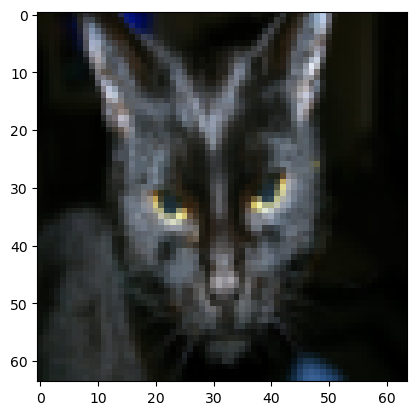

In [6]:
# Example of a 'cat' image
index = 25
plt.imshow(train_set_x_orig[index])
print ("y = " + str(train_set_y[:, index]) + ", it's a '" + classes[np.squeeze(train_set_y[:, index])].decode("utf-8") +  "' picture.")
plt.savefig('preview.png', bbox_inches='tight')

y = [0], it's a 'non-cat' picture.


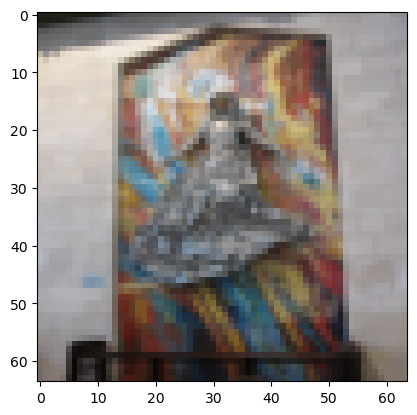

In [7]:
# Example of a 'not-cat' image
index = 86
plt.imshow(train_set_x_orig[index])
print ("y = " + str(train_set_y[:, index]) + ", it's a '" + classes[np.squeeze(train_set_y[:, index])].decode("utf-8") +  "' picture.")

y = [0], it's a 'non-cat' picture.


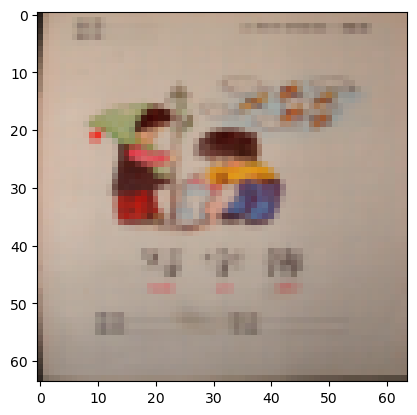

In [8]:
# A random picture from the training set
index = np.random.randint(209)
plt.imshow(train_set_x_orig[index])
print ("y = " + str(train_set_y[:, index]) + ", it's a '" + classes[np.squeeze(train_set_y[:, index])].decode("utf-8") +  "' picture.")

In [9]:
m_train = train_set_x_orig.shape[0]
m_test = test_set_x_orig.shape[0]
num_px = train_set_x_orig.shape[1]

print ("Number of training examples: m_train = " + str(m_train))
print ("Number of testing examples: m_test = " + str(m_test))
print ("Height/Width of each image: num_px = " + str(num_px))
print ("Each image is of size: (" + str(num_px) + ", " + str(num_px) + ", 3)")
print ("train_set_x shape: " + str(train_set_x_orig.shape))
print ("train_set_y shape: " + str(train_set_y.shape))
print ("test_set_x shape: " + str(test_set_x_orig.shape))
print ("test_set_y shape: " + str(test_set_y.shape))

Number of training examples: m_train = 209
Number of testing examples: m_test = 50
Height/Width of each image: num_px = 64
Each image is of size: (64, 64, 3)
train_set_x shape: (209, 64, 64, 3)
train_set_y shape: (1, 209)
test_set_x shape: (50, 64, 64, 3)
test_set_y shape: (1, 50)


In [10]:
train_set_x_flatten = train_set_x_orig.reshape(train_set_x_orig.shape[0],-1).T
test_set_x_flatten = test_set_x_orig.reshape(test_set_x_orig.shape[0],-1).T

print ("train_set_x_flatten shape: " + str(train_set_x_flatten.shape))
print ("train_set_y shape: " + str(train_set_y.shape))
print ("test_set_x_flatten shape: " + str(test_set_x_flatten.shape))
print ("test_set_y shape: " + str(test_set_y.shape))

train_set_x_flatten shape: (12288, 209)
train_set_y shape: (1, 209)
test_set_x_flatten shape: (12288, 50)
test_set_y shape: (1, 50)


In [11]:
# Standardizing the feature data
train_set_x = train_set_x_flatten / 255.
test_set_x = test_set_x_flatten / 255.

# 2. <a id='toc2_'></a>[THE SIGMOID](#toc0_)

The [sigmoid function](https://en.wikipedia.org/wiki/Sigmoid_function) $\sigma$ is defined as

$$\sigma: \mathbb{R} \to \left(0,1\right)$$

\begin{align*}
\sigma(x) &= \frac{1}{1 + e^{-x}}\\[0.1cm]
\end{align*}

$\sigma$ is non-linear, smooth and strictly increasing. It is the activation function of choice for the output layer of neural networks built for binary classification problems. In particular, logistic regression uses the sigmoid to extract a prediction of the label for a given feature vector.

In [12]:
def sigmoid(z):
    """
    Compute the sigmoid of z

    Arguments:
    z -- A scalar or numpy array of any size.

    Return:
    s -- sigmoid(z)
    """
    return 1/(1+np.exp(-z))

This implementation of the sigmoid, using `numpy.exp` instead of `math.exp`, allows it to be applied to a NumPy array element-wise. This allows a more computationally efficient implementation of logistic regression. Using this property to plot a graph of $\sigma$ on $\mathbb{R}$:

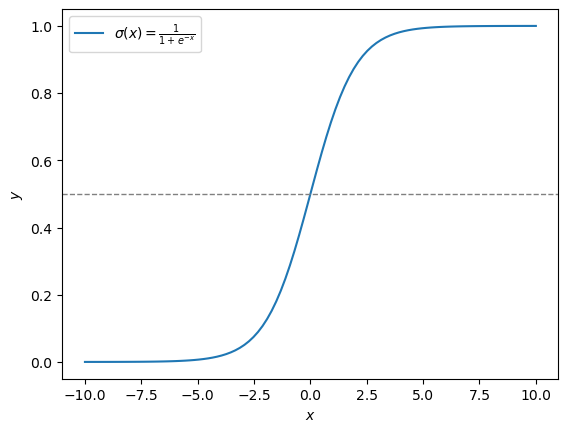

In [13]:
x_values = np.linspace(-10,10,100)
y_values = sigmoid(x_values) # Applying the sigmoid to each element of the x_values array
plt.plot(x_values,y_values,label=r'$\sigma (x) = \frac{1}{1 + e^{-x}}$')

plt.axhline(0.5, color='gray', linestyle='--', linewidth=1)
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.legend()

**LEMMA:**

The derivative $\sigma'$ of the sigmoid $\sigma$ satisfies

$$\sigma'(x) = \sigma(x)\left(1-\sigma(x)\right)$$

*Proof*:



# 3. <a id='toc3_'></a>[LOGISTIC REGRESSION AND GRADIENT DESCENT](#toc0_)

The following image illustrates how [logistic regression](https://en.wikipedia.org/wiki/Logistic_regression) may be viewed as a [perceptron](https://en.wikipedia.org/wiki/Perceptron) with sigmoid activation.

<img src="percep.png" style="width:650px;height:400px;">

## 3.1. <a id='toc3_1_'></a>[Mathematical expression of the algorithm](#toc0_)

For one training example $\left(x^{(i)},y^{(i)}\right)\in \mathbb{R}^n \times \{0,1\}$ in the training set $\left\{ \left(x^{(i)} , y^{(i)} \right) \right\} _{i=1}^{m}$ and a choice of parameters $w\in\mathbb{R}^{n}\,$, $b\in\mathbb{R}$, **forward propagation** consists of computing the **prediction** $\hat y^{(i)}\in(0,1)$ of the model as $x \mapsto \left(w\cdot x + b\right) \mapsto \sigma\left( w\cdot x + b \right)$. That is, 

$$z^{(i)} = w \cdot x^{(i)} + b$$

$$\hat{y}^{(i)} = a^{(i)} = \sigma\left(z^{(i)}\right)$$ 

where $\sigma: \mathbb{R} \to \left(0,1\right)$ is the sigmoid defined above, $n$ is the number of features (length of any of the vectors $x$) and $m = m_{\text{train}}$ is the number of training examples. The scalar $a^{(i)}$ is the **activation** of the perceptron, which is numerically equal to the output $\hat y^{(i)}$ for a neural network with no hidden layers such as logistic regression.



The prediction $\hat{y}^{(i)}\in \left(0,1\right)$ is interpreted as the probability that $x^{(i)}$ is in class 1 (i.e. is an image of a cat)

$$\hat{y}^{(i)} = \mathbb{P}\left( y^{(i)}=1 \,|\, x^{(i)} \,; \,w, b \right)$$

We can extract a binary prediction in $\{0,1\} \equiv \{\text{non-cat},\text{cat}\}$ from the prediction $\hat{y}^{(i)}$ by applying a threshold
$$y^{(i)}_{\text{pred}} = \mathbb{1} {\left\{a^{(i)} > 0.5\right\}} = \begin{cases}
      1 & \text{if}\ a^{(i)} > 0.5 \\
      0 & \text{otherwise}
    \end{cases}
$$  


Such a threshold can be implemented in code using, for example, `numpy.round`.

*Training the model* consists of using the training data to find parameters $w,\, b$ solving the optimization problem 
$$
\min_{w\in\mathbb{R}^n,\,b\in\mathbb{R}} J(w, b)
$$
where $J = J(w,b): \mathbb{R}^n \times \mathbb{R} \rightarrow [0,\infty)$ is the **cost function** defined in terms of a **loss function** $\mathcal{L}$. The loss function $\mathcal{L}$ measures the error between the model's prediction $\hat y^{(i)} = a^{(i)}\in(0,1)$ for one of the training examples $x^{(i)}\in\mathbb{R}^n$ and the true label $y^{(i)}\in\{0,1\}.$

We use the [binary cross entropy](https://en.wikipedia.org/wiki/Cross-entropy#Cross-entropy_loss_function_and_logistic_regression) (negative log-loss) loss function $\mathcal{L}$, defined as

\begin{align*}
\mathcal{L}\left(a, y\right) &=  - y  \log a - \left(1-y \right)  \log\left(1-a\right)\\[0.2cm]
&= \begin{cases} 
- \log\left(a\right) & \text{if } y = 1 \\
- \log\left(1 - a\right) & \text{if } y = 0 
\end{cases}
\end{align*}

The (unregularized) cost $J$ is then computed by summing over all training examples:

\begin{align*}
J(w,b) &= \frac{1}{m} \sum_{i=1}^{m} \mathcal{L}\left(a^{(i)}, y^{(i)}\right)\\[0.2cm]
  &= -\frac{1}{m} \sum_{i=1}^{m} \left[ y^{(i)}  \log\left(a^{(i)}\right) + \left(1-y^{(i)} \right)  \log\left(1-a^{(i)}\right) \right]
\end{align*}

To counteract *overfitting* of the model to the training data one can include a **regularization** term in the cost function to penalise large weights $w$. For example, with an $L_2$-regularization term the cost $J$ becomes

$$J(w,b) = \frac{1}{m} \sum_{i=1}^{m} \mathcal{L}\left(a^{(i)}, y^{(i)}\right) + \frac{\lambda}{2m}||w||_2^2$$

where $\lambda \geq 0$ is the **regularization parameter** and $||w||_2^2 = w_1^2 + w_2^2 + \dots + w_n^2 = w \cdot w$ denotes the squared Euclidean norm of $w$.

**Backpropagation** consists of computing the derivatives 

$$\frac{\partial J (w,b)}{\partial w_j},\, \frac{\partial J(w,b)}{\partial b}$$

for use when optimizing $(w,b)$ using gradient descent. It is easy to compute that in the unregularized case:

\begin{align*}
\frac{\partial J (w,b)}{\partial w_j} &= \frac{1}{m}\sum_{i=1}^m \left(a^{(i)} - y^{(i)}\right)x_j^{(i)}\\
\frac{\partial J(w,b)}{\partial b} &= \frac{1}{m}\sum_{i=1}^m \left(a^{(i)} - y^{(i)}\right)
\end{align*}

While in the $L_2$-regularized case:

\begin{align*}
\frac{\partial J (w,b)}{\partial w_j} &= \frac{1}{m}\sum_{i=1}^m \left(a^{(i)} - y^{(i)}\right)x_j^{(i)} +\frac{\lambda}{m}w_j  \\
\frac{\partial J(w,b)}{\partial b} &= \frac{1}{m}\sum_{i=1}^m \left(a^{(i)} - y^{(i)}\right)
\end{align*}

## 3.2. <a id='toc3_2_'></a>[Vectorization](#toc0_)

Looping over all the $m$ training examples $\left (x^{(i)},y^{(i)} \right)$ in turn to calculate $\hat{y}^{(i)} = a^{(i)} = \sigma\left(z^{(i)}\right) = \sigma\left( w \cdot x^{(i)} + b\right)$ and $\mathcal{L}\left(a^{(i)}, y^{(i)}\right)$ is computationally inefficient if $m$ is large $\left(\text{e.g.}\,\, m\sim10^6\right)$ as is common in modern industry applications.


By turning to a so called *vectorized* implementation we can take advantage of NumPy's powerful numerical linear algebra capabilities to implement forward propagation more efficiently.


Define vectors $Z = \left( z^{(1)}, z^{(2)}, \dots, z^{(m)} \right) \in \mathbb{R}^m$ and $A = \left( a^{(1)}, a^{(2)}, \dots, a^{(m)} \right) \in \mathbb{R}^m$. Define the $n\,\times\,m$ matrix $X$ with $i^{\text{th}}$ column $x^{(i)}$. That is,

\begin{equation}
X = \begin{bmatrix}
    | & | & \cdots & | \\
    x^{(1)} & x^{(2)} & \cdots & x^{(m)} \\
    | & | & \cdots & |
\end{bmatrix}\in \mathcal{M}_{n,m} \left(\mathbb{R}\right)
\end{equation}

Then

\begin{align*}
w^T X + \left(b,b,\dots,b\right) &= \left( w^T x^{(1)}+b, \,w^T x^{(2)}+b, \dots ,\,w^T x^{(n)}+b \right)\\[0.2cm]
                                 &= \left( z^{(1)}, z^{(2)}, \dots, z^{(m)} \right)\\[0.2cm]
                                 &= Z
\end{align*}

So if $\mathbf{b} = \left(b,b,\dots,b\right)$ then $Z = w^T X + \mathbf{b}$. 

We can implement this in code as `Z = np.dot(w.T,X) + b` where we have taken advantage of [python broadcasting](https://numpy.org/doc/stable/user/basics.broadcasting.html) to add the scalar `b` to the array `np.dot(w.T,X)`. NumPy then interprets this addition as element-wise. We then have 
$$A = \left( a^{(1)}, a^{(2)}, \dots, a^{(m)} \right) = \sigma (Z)$$
since the sigmoid $\sigma$ acts on arrays element-wise.

`A = sigmoid(np.dot(w.T,X) + b)` is a computationally efficient implementation of forward propagation across the entire training set at once. In particular, this is more efficient than using a `for` loop to iterate over each training example in turn.

## 3.3. <a id='toc3_3_'></a>[Gradient Descent](#toc0_)

The optimization problem
$$
\min_{w\in\mathbb{R}^n,\,b\in\mathbb{R}} J(w, b)
$$

is numerically solved by [gradient descent](https://en.wikipedia.org/wiki/Gradient_descent). For our purposes, gradient descent comprises of iteratively and simultaneously updating $b$ and $w$ according to 

\begin{align*}
w_j &\mapsto w_j - \alpha \frac{\partial J(w,b)}{\partial w_j}\\[0.1cm]
b &\mapsto b - \alpha \frac{\partial J(w,b)}{\partial b}
\end{align*}

where $\alpha << 1$ is a fixed hyperparameter called the *learning rate*. Another hyperparameter introduced with gradient descent is the number of iterations `num_interations` to repeat this updating process.

# 4. <a id='toc4_'></a>[THE UNREGULARIZED MODEL](#toc0_)

## 4.1. <a id='toc4_1_'></a>[Helper Functions](#toc0_)

In [14]:
def initialize_with_zeros(dim):
    """
    Create a vector of zeros of shape (dim, 1) for w and initializes b to 0.
    
    Argument:
    dim -- size of the w vector we want (int)
    
    Returns:
    w -- initialized vector of shape (dim, 1)
    b -- initialized scalar (corresponds to the bias) of type float
    """
    w = np.zeros((dim,1))
    b = float(0)
    
    return w, b

In [15]:
def forward_propagate(w, b, X):
    """
    Implements forward propogation across the training set X, computing the activation matrix A 
    
    Arguments:
    w -- weights, a numpy array of size (num_px * num_px * 3, 1)
    b -- bias, a scalar
    X -- data of shape (num_px * num_px * 3, number of examples)

    Returns:
    A -- activation of the neuron, numpy array of size (num_px * num_px * 3, number of examples)
    """
    A = sigmoid(np.dot(w.T,X)+b)
    return A

In [16]:
def compute_cost(w, b, X, Y):
    '''
    Computes the negative log-likelihood cost J(w,b) across the training set    
    
    Arguments:
    w -- weights, a numpy array of size (num_px * num_px * 3, 1)
    b -- bias, a scalar
    X -- data of shape (num_px * num_px * 3, number of examples)
    Y -- true "label" vector (containing 0 if non-cat, 1 if cat), of shape (1, number of examples)
    
    Returns:
    cost -- negative log-likelihood cost for logistic regression
    '''
    m = X.shape[1]
    A = forward_propagate(w, b, X)
    cost = (-1/m) * (np.dot(Y, np.log(A).T) + np.dot((1 - Y), np.log(1 - A).T))
    cost = np.squeeze(np.array(cost))  
    return cost

In [17]:
def backward_propagate(w, b, X, Y):
    '''
    Calculates the gradient of the cost function J with respect to the parameters w, b
    
    Arguments:
    w -- weights, a numpy array of size (num_px * num_px * 3, 1)
    b -- bias, a scalar
    X -- data of shape (num_px * num_px * 3, number of examples)
    Y -- true "label" vector (containing 0 if non-cat, 1 if cat), of shape (1, number of examples)
    
    Returns:
    grads -- dictionary containing the gradients of J w.r.t. the weights and bias
            (dw -- gradient of the loss with respect to w, thus same shape as w)
            (db -- gradient of the loss with respect to b, thus same shape as b)
    '''
    m = X.shape[1]
    
    A = forward_propagate(w, b, X)
    
    dw = (1/m)*np.dot(X,(A-Y).T)
    db = (1/m)*np.sum(A-Y)
    
    grads = {"dw": dw,
             "db": db}
    
    return grads

In [18]:
def optimize(w, b, X, Y, num_iterations=3000, learning_rate=0.005, print_cost=False):
    """
    Optimizes w and b by running a gradient descent algorithm
    
    Arguments:
    w -- weights, a numpy array of size (num_px * num_px * 3, 1)
    b -- bias, a scalar
    X -- data of shape (num_px * num_px * 3, number of examples)
    Y -- true "label" vector (containing 0 if non-cat, 1 if cat), of shape (1, number of examples)
    num_iterations -- number of iterations of the optimization loop
    learning_rate -- learning rate of the gradient descent update rule
    print_cost -- True to print the loss every 100 steps
    
    Returns:
    params -- dictionary containing the weights w and bias b
    grads -- dictionary containing the gradients of the weights and bias with respect to the cost function
    costs -- list of all the costs computed during the optimization, this will be used to plot the learning curve.
    """
    
    costs = []
    
    for i in range(num_iterations):
        
        cost = compute_cost(w, b, X, Y)
        grads = backward_propagate(w, b, X, Y)
        
        dw = grads["dw"]
        db = grads["db"]
        
        w = w - learning_rate*dw
        b = b - learning_rate*db
 
        if i % 100 == 0:
            costs.append(cost)
        
            # Print the cost every 100 training iterations
            if print_cost:
                print ("Cost after iteration %i: %f" %(i, cost))
    
    params = {"w": w,
              "b": b}
    
    grads = {"dw": dw,
             "db": db}
    
    return params, grads, costs

In [19]:
def predict(w, b, X):
    '''
    Predict whether the label is 0 or 1 using learned logistic regression parameters (w, b) outputted from `optimize`
    
    Arguments:
    w -- weights, a numpy array of size (num_px * num_px * 3, 1)
    b -- bias, a scalar
    X -- data of size (num_px * num_px * 3, number of examples)
    
    Returns:
    Y_prediction -- a numpy array (vector) containing all predictions (0/1) for the examples in X
    '''
    
    m = X.shape[1]
    Y_prediction = np.zeros((1, m))
    
    w = w.reshape(X.shape[0], 1)

    A = sigmoid(np.dot(w.T,X)+b) 

    for i in range(A.shape[1]):        
        Y_prediction[0,i] = np.round(A[0,i]) # Applies a threshold of 0.5
    
    return Y_prediction

## 4.2. <a id='toc4_2_'></a>[Combining into logistic regression](#toc0_)
Combining the previously defined functions `intialize_with_zeros`, `propagate`, `optimize` and `predict` into the logistic regression model

In [20]:
def model(X_train, Y_train, X_test, Y_test, num_iterations=3000, learning_rate=0.005, print_cost=False):
    """
    Combines the helper functions to construct the unregularized logistic regression model
    
    Arguments:
    X_train -- training set represented by a numpy array of shape (num_px * num_px * 3, m_train)
    Y_train -- training labels represented by a numpy array (vector) of shape (1, m_train)
    X_test -- test set represented by a numpy array of shape (num_px * num_px * 3, m_test)
    Y_test -- test labels represented by a numpy array (vector) of shape (1, m_test)
    num_iterations -- hyperparameter representing the number of iterations to optimize the parameters
    learning_rate -- hyperparameter representing the learning rate used in the update rule of optimize()
    print_cost -- Set to True to print the cost every 100 iterations
    
    Returns:
    d -- dictionary containing information about the model.
    """
    w, b = initialize_with_zeros(X_train.shape[0])
    
    params, grads, costs = optimize(w, b, X_train, Y_train, num_iterations, learning_rate, print_cost=False)
    
    w = params['w']
    b = params['b']
    
    Y_prediction_test = predict(w,b,X_test)
    Y_prediction_train = predict(w,b,X_train)

    # Print train/test Errors
    if print_cost:
        print("train accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_train - Y_train)) * 100))
        print("test accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_test - Y_test)) * 100))

    d = {"costs": costs,
         "Y_prediction_test": Y_prediction_test, 
         "Y_prediction_train" : Y_prediction_train, 
         "w" : w, 
         "b" : b,
         "learning_rate" : learning_rate,
         "num_iterations": num_iterations}
    
    return d

In [21]:
logistic_regression_model = model(train_set_x, 
                                  train_set_y, 
                                  test_set_x,
                                  test_set_y,
                                  num_iterations=3000,
                                  learning_rate=0.005,
                                  print_cost=True)

train accuracy: 99.52153110047847 %
test accuracy: 68.0 %


The model accuractely classified >99% of the images in the training set and 70% of the images in the test set, suggesting that we are experiences overfitting to our training data. 

## 4.3. <a id='toc4_3_'></a>[Errors and learning curves](#toc0_)

y = 1, predicted as "non-cat" picture.


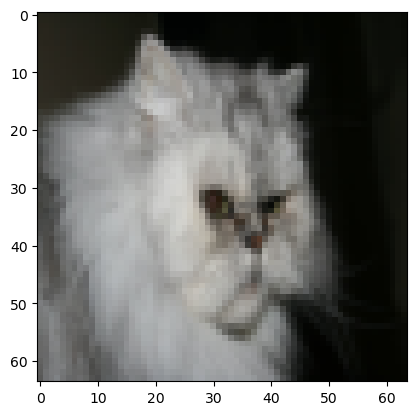

In [22]:
# Example of a 'cat' that was inaccuractely classified as 'not-cat' (False Negative)
index = 10
plt.imshow(test_set_x[:, index].reshape((num_px, num_px, 3)))
print ("y = " + str(test_set_y[0,index]) + ", predicted as \"" + classes[int(logistic_regression_model['Y_prediction_test'][0,index])].decode("utf-8") +  "\" picture.")

y = 0, predicted as "cat" picture.


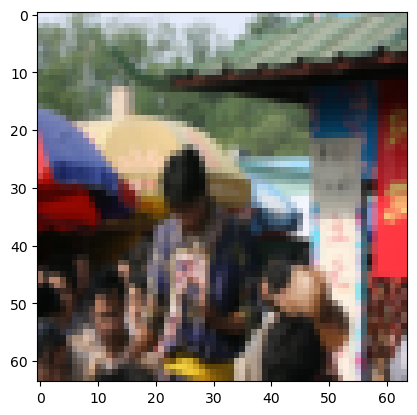

In [23]:
# Example of a 'not-cat' that was inaccuractely classified as 'cat' (False Positive)
index = 34
plt.imshow(test_set_x[:, index].reshape((num_px, num_px, 3)))
print ("y = " + str(test_set_y[0,index]) + ", predicted as \"" + classes[int(logistic_regression_model['Y_prediction_test'][0,index])].decode("utf-8") +  "\" picture.")

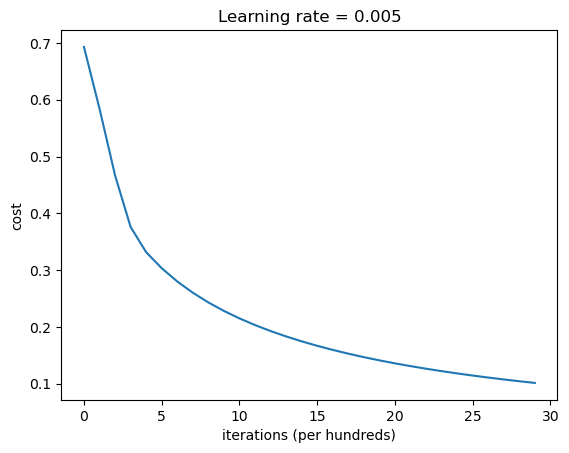

In [24]:
# Plot learning curve (with costs)
costs = np.squeeze(logistic_regression_model['costs'])
plt.plot(costs)
plt.ylabel('cost')
plt.xlabel('iterations (per hundreds)')
plt.title("Learning rate = " + str(logistic_regression_model["learning_rate"]))
plt.show()

## 4.4. <a id='toc4_4_'></a>[Animal Testing](#toc0_)

In [25]:
def is_cat(image_str):
    '''
    Applies the trained logistic regression model to predict if an inputted image is a cat (y=1) or a non-cat (y=0)
    
    Arguments:
    image_str - a string encoding the file name of the .jpg file, 
                e.g. 'cat.jpg' if cat.jpg is the file name of an image saved in the same directory as this notebook.
    Returns:
    None
    '''
    # Read the original image
    original_image = np.array(Image.open(image_str))
    
    # Show the original image
    plt.subplot(1, 2, 1)
    plt.imshow(original_image)
    plt.title("Original Image")
    
    # Resize the image to 64x64
    resized_image = np.array(Image.open(image_str).resize((num_px, num_px)))
    
    # Show the resized image
    plt.subplot(1, 2, 2)
    plt.imshow(resized_image)
    plt.title("Resized Image (64x64)")
    
    # Standardize and flatten the resized image 
    image = resized_image / 255.
    image = image.reshape((1, num_px * num_px * 3)).T
    
    # Predict label using training logistic regression model
    my_predicted_image = predict(logistic_regression_model["w"], logistic_regression_model["b"], image)
    
    # Print the prediction for the resized image
    print("y = " + str(int(np.squeeze(my_predicted_image))) + ", the model predicts this is a \"" + classes[int(np.squeeze(my_predicted_image)),].decode("utf-8") +  "\" picture.")

Let's test the function `is_cat` on an image of my own cat, William. \
He's middle-aged and overweight.

y = 0, the model predicts this is a "non-cat" picture.


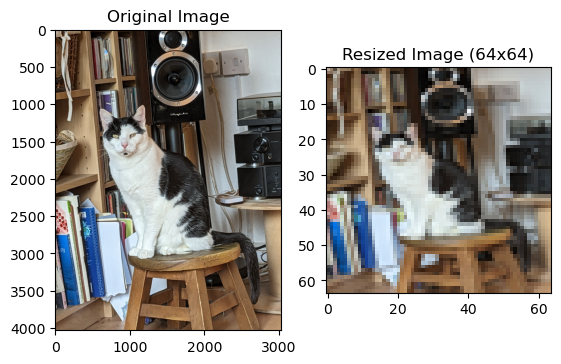

In [26]:
is_cat('william.jpg')

Unsuprising. He's always been a disappointment.\
Observing on some other images in my camera roll:

y = 1, the model predicts this is a "cat" picture.


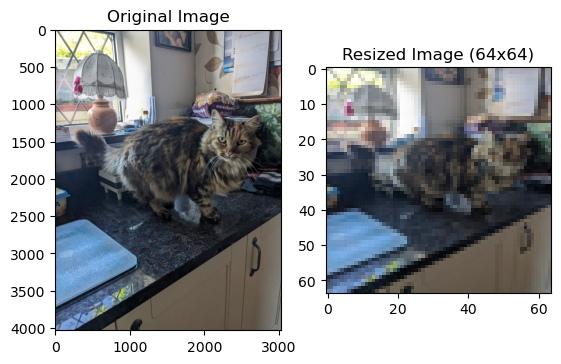

In [27]:
is_cat('flora.jpg')

y = 0, the model predicts this is a "non-cat" picture.


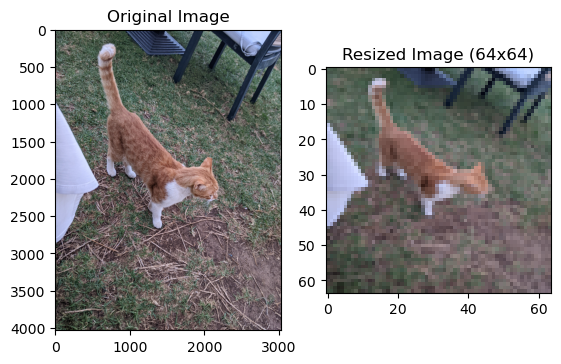

In [28]:
is_cat('ginger_greek_cat.jpg')

y = 1, the model predicts this is a "cat" picture.


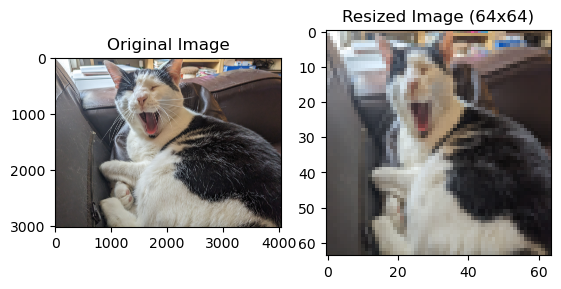

In [29]:
is_cat('william_yawning.jpg')

y = 1, the model predicts this is a "cat" picture.


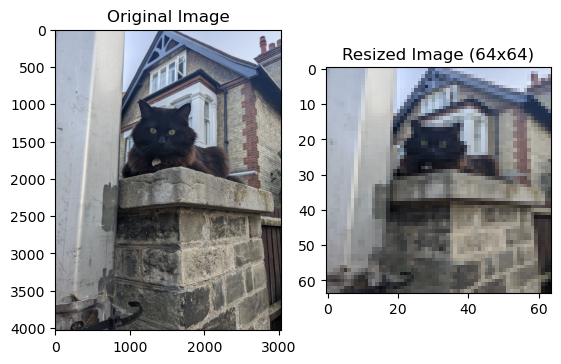

In [30]:
is_cat('cambridge_cat.jpg')

y = 0, the model predicts this is a "non-cat" picture.


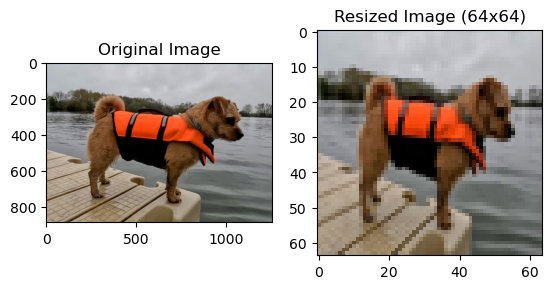

In [31]:
is_cat('lexi.jpg')

y = 1, the model predicts this is a "cat" picture.


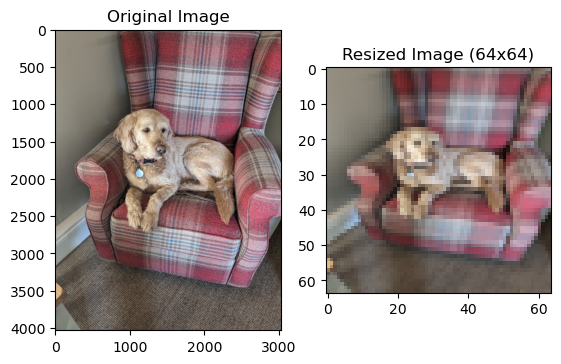

In [32]:
is_cat('toby.jpg')

y = 0, the model predicts this is a "non-cat" picture.


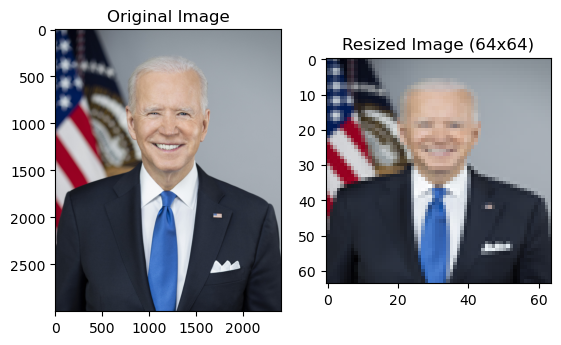

In [33]:
is_cat('mr_president.jpg')

y = 1, the model predicts this is a "cat" picture.


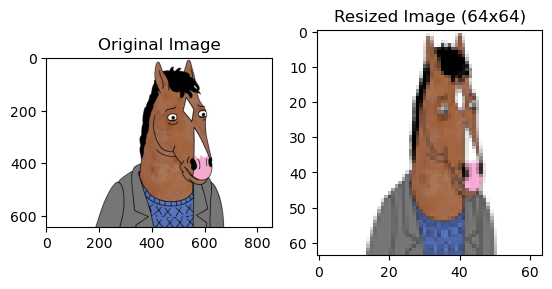

In [34]:
is_cat('bojack.jpg')

y = 0, the model predicts this is a "non-cat" picture.


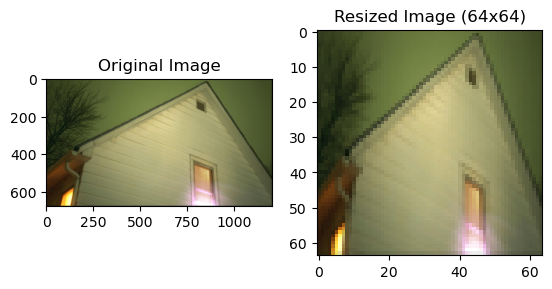

In [35]:
is_cat('american_football.jpg')

Oh dear. Time to do some tuning.

# 5. <a id='toc5_'></a>[THE L2-REGULARIZED MODEL](#toc0_)


## 5.1. <a id='toc5_1_'></a>[Regularizing the helper functions](#toc0_)

In [36]:
def compute_cost_regularized(w, b, X, Y, lambda_):
    '''
    Computes the L2-regularized negative log-likelihood cost J(w,b) across the training set
    
    Arguments:
    w -- weights, a numpy array of size (num_px * num_px * 3, 1)
    b -- bias, a scalar
    X -- data of shape (num_px * num_px * 3, number of examples)
    Y -- true "label" vector (containing 0 if non-cat, 1 if cat), of shape (1, number of examples)
    lambda_ -- regularization hyperparameter
    
    Returns:
    cost -- L2-regularized negative log-likelihood cost for logistic regression
    '''
    m = X.shape[1]
    reg_cost = compute_cost(w, b, X, Y) + (lambda_/m)*(np.linalg.norm(w)**2)
    
    return reg_cost

In [37]:
def backward_propagate_regularized(w, b, X, Y, lambda_):
    '''
    Calculates the gradient of the L2-regularized cost function J with respect to the parameters w, b
    
    Arguments:
    w -- weights, a numpy array of size (num_px * num_px * 3, 1)
    b -- bias, a scalar
    X -- data of shape (num_px * num_px * 3, number of examples)
    Y -- true "label" vector (containing 0 if non-cat, 1 if cat), of shape (1, number of examples)
    lambda_ -- regularization hyperparameter
    
    Returns:
    grads -- dictionary containing the gradients of J w.r.t. the weights and bias
            (dw -- gradient of the loss with respect to w, thus same shape as w)
            (db -- gradient of the loss with respect to b, thus same shape as b)
    '''
    m = X.shape[1]
    grads = backward_propagate(w, b, X, Y)
    grads['dw'] = grads['dw'] + (lambda_/m)*w
    
    return grads

In [38]:
def optimize_regularized(w, b, X, Y, num_iterations=3000, learning_rate=0.005, lambda_=0, print_cost=False):
    """
    Optimizes w and b by running a gradient descent algorithm on the regularized cost function
    
    Arguments:
    w -- weights, a numpy array of size (num_px * num_px * 3, 1)
    b -- bias, a scalar
    X -- data of shape (num_px * num_px * 3, number of examples)
    Y -- true "label" vector (containing 0 if non-cat, 1 if cat), of shape (1, number of examples)
    num_iterations -- number of iterations of the optimization loop
    learning_rate -- learning rate of the gradient descent update rule
    lambda_ -- regularization hyperparameter
    print_cost -- True to print the loss every 100 steps
    
    Returns:
    params -- dictionary containing the weights w and bias b
    grads -- dictionary containing the gradients of the weights and bias with respect to the cost function
    costs -- list of all the costs computed during the optimization, this will be used to plot the learning curve.
    """
    
    costs = []
    
    for i in range(num_iterations):
        
        cost = compute_cost_regularized(w, b, X, Y, lambda_)
        grads = backward_propagate_regularized(w, b, X, Y, lambda_)
        
        dw = grads["dw"]
        db = grads["db"]
        
        w = w - learning_rate*dw
        b = b - learning_rate*db
 
        if i % 100 == 0:
            costs.append(cost)
        
            # Print the cost every 100 training iterations
            if print_cost:
                print ("Cost after iteration %i: %f" %(i, cost))
    
    params = {"w": w,
              "b": b}
    
    grads = {"dw": dw,
             "db": db}
    
    return params, grads, costs

## 5.2. <a id='toc5_2_'></a>[Combining into regularized logistic regression](#toc0_)

In [39]:
def regularized_model(X_train, Y_train, X_test, Y_test, num_iterations=3000, learning_rate=0.5, lambda_=0, print_cost=False):
    """
    Combines the helper functions to construct the regularized model
    
    Arguments:
    X_train -- training set represented by a numpy array of shape (num_px * num_px * 3, m_train)
    Y_train -- training labels represented by a numpy array (vector) of shape (1, m_train)
    X_test -- test set represented by a numpy array of shape (num_px * num_px * 3, m_test)
    Y_test -- test labels represented by a numpy array (vector) of shape (1, m_test)
    num_iterations -- hyperparameter representing the number of iterations to optimize the parameters
    learning_rate -- hyperparameter representing the learning rate used in the update rule of optimize()
    lambda_ -- regularization hyperparameter
    print_cost -- Set to True to print the cost every 100 iterations
    
    Returns:
    d -- dictionary containing information about the model.
    """
    w, b = initialize_with_zeros(X_train.shape[0])
    
    params, grads, costs = optimize_regularized(w, b, X_train, Y_train, num_iterations, learning_rate, lambda_, print_cost=False)
    
    w = params['w']
    b = params['b']
    
    Y_prediction_test = predict(w,b,X_test)
    Y_prediction_train = predict(w,b,X_train)

    # Print train/test Errors
    if print_cost:
        print("train accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_train - Y_train)) * 100))
        print("test accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_test - Y_test)) * 100))

    d = {"costs": costs,
         "Y_prediction_test": Y_prediction_test, 
         "Y_prediction_train" : Y_prediction_train, 
         "w" : w, 
         "b" : b,
         "learning_rate" : learning_rate,
         "num_iterations": num_iterations}
    
    return d

In [40]:
logistic_regression_model_regularized = regularized_model(train_set_x,
                                                          train_set_y,
                                                          test_set_x,
                                                          test_set_y,
                                                          num_iterations=3000,
                                                          learning_rate=0.005,
                                                          lambda_=100,
                                                          print_cost=True)

train accuracy: 89.47368421052632 %
test accuracy: 74.0 %


## 5.3. <a id='toc5_3_'></a>[Tuning the regularization parameter](#toc0_)

In [41]:
def tune_lambda(lambdas):
    '''
    Trains the regularized model with a choice of different regularization hyperparameters lambda_
    
    Arguments:
    lambdas - a list of regularization hyperparameters lambda_
    
    Returns:
    None
    '''
    for lambda_ in lambdas:
        print(f"Training a model with regularization parameter lambda = {lambda_}")
        regularized_model(train_set_x,
                          train_set_y,
                          test_set_x,
                          test_set_y,
                          num_iterations=3000,
                          learning_rate=0.005,
                          lambda_=lambda_,
                          print_cost=True)
        print("\n") 

In [42]:
lambdas = [0, 50, 100, 150, 200, 250]
tune_lambda(lambdas)

Training a model with regularization parameter lambda = 0
train accuracy: 99.52153110047847 %
test accuracy: 68.0 %


Training a model with regularization parameter lambda = 50
train accuracy: 95.69377990430623 %
test accuracy: 74.0 %


Training a model with regularization parameter lambda = 100
train accuracy: 89.47368421052632 %
test accuracy: 74.0 %


Training a model with regularization parameter lambda = 150
train accuracy: 84.21052631578948 %
test accuracy: 80.0 %


Training a model with regularization parameter lambda = 200
train accuracy: 75.59808612440192 %
test accuracy: 82.0 %


Training a model with regularization parameter lambda = 250
train accuracy: 72.72727272727273 %
test accuracy: 82.0 %




In [43]:
lambdas = [130, 140, 150, 160, 170]
tune_lambda(lambdas)

Training a model with regularization parameter lambda = 130
train accuracy: 87.08133971291866 %
test accuracy: 80.0 %


Training a model with regularization parameter lambda = 140
train accuracy: 87.08133971291866 %
test accuracy: 80.0 %


Training a model with regularization parameter lambda = 150
train accuracy: 84.21052631578948 %
test accuracy: 80.0 %


Training a model with regularization parameter lambda = 160
train accuracy: 81.33971291866028 %
test accuracy: 82.0 %


Training a model with regularization parameter lambda = 170
train accuracy: 80.38277511961722 %
test accuracy: 82.0 %




In [44]:
lambdas = [150, 152, 154, 156, 158, 160]
tune_lambda(lambdas)

Training a model with regularization parameter lambda = 150
train accuracy: 84.21052631578948 %
test accuracy: 80.0 %


Training a model with regularization parameter lambda = 152
train accuracy: 83.73205741626793 %
test accuracy: 82.0 %


Training a model with regularization parameter lambda = 154
train accuracy: 83.25358851674642 %
test accuracy: 82.0 %


Training a model with regularization parameter lambda = 156
train accuracy: 83.25358851674642 %
test accuracy: 82.0 %


Training a model with regularization parameter lambda = 158
train accuracy: 82.29665071770334 %
test accuracy: 82.0 %


Training a model with regularization parameter lambda = 160
train accuracy: 81.33971291866028 %
test accuracy: 82.0 %




## 5.4. <a id='toc5_4_'></a>[More animal testing](#toc0_)

In [45]:
tuned_regularized_model = regularized_model(train_set_x,
                                            train_set_y,
                                            test_set_x,
                                            test_set_y,
                                            num_iterations=3000,
                                            learning_rate=0.005,
                                            lambda_=152,
                                            print_cost=True)

train accuracy: 83.73205741626793 %
test accuracy: 82.0 %


In [46]:
def is_cat_tuned_regularized(image_str):
    '''
    Applies the trained regularized & tuned logistic regression model to predict if an inputted image is a cat (y=1) or a non-cat (y=0)
    
    Arguments:
    image_str - a string encoding the file name of the .jpg file, 
                e.g. 'cat.jpg' if cat.jpg is the file name of an image saved in the same directory as this notebook.
    Returns:
    None
    '''
    # Read the original image
    original_image = np.array(Image.open(image_str))
    
    # Show the original image
    plt.subplot(1, 2, 1)
    plt.imshow(original_image)
    plt.title("Original Image")
    
    # Resize the image to 64x64
    resized_image = np.array(Image.open(image_str).resize((num_px, num_px)))
    
    # Show the resized image
    plt.subplot(1, 2, 2)
    plt.imshow(resized_image)
    plt.title("Resized Image (64x64)")
    
    # Standardize and flatten the resized image 
    image = resized_image / 255.
    image = image.reshape((1, num_px * num_px * 3)).T
    
    # Predict label using training logistic regression model
    my_predicted_image = predict(tuned_regularized_model["w"], tuned_regularized_model["b"], image)
    
    # Print the prediction for the resized image
    print("y = " + str(int(np.squeeze(my_predicted_image))) + ", the model predicts this is a \"" + classes[int(np.squeeze(my_predicted_image)),].decode("utf-8") +  "\" picture.")

y = 1, the model predicts this is a "cat" picture.


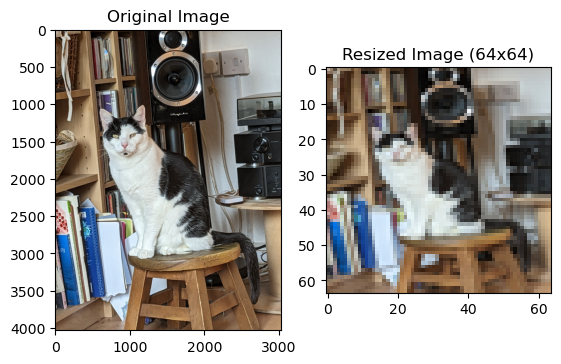

In [47]:
is_cat_tuned_regularized('william.jpg')

y = 1, the model predicts this is a "cat" picture.


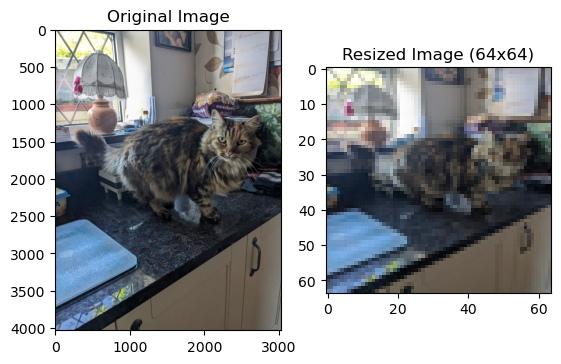

In [48]:
is_cat_tuned_regularized('flora.jpg')

y = 1, the model predicts this is a "cat" picture.


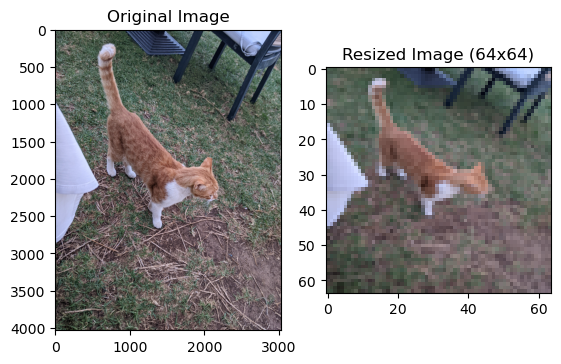

In [49]:
is_cat_tuned_regularized('ginger_greek_cat.jpg')

y = 1, the model predicts this is a "cat" picture.


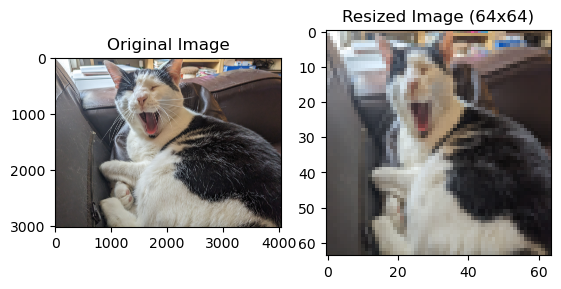

In [50]:
is_cat_tuned_regularized('william_yawning.jpg')

y = 1, the model predicts this is a "cat" picture.


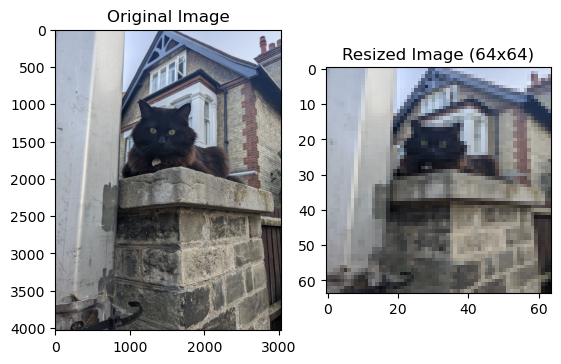

In [51]:
is_cat_tuned_regularized('cambridge_cat.jpg')

y = 1, the model predicts this is a "cat" picture.


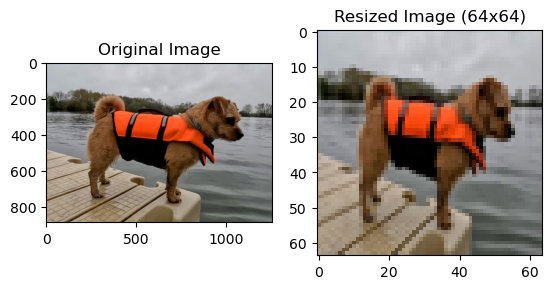

In [52]:
is_cat_tuned_regularized('lexi.jpg')

y = 1, the model predicts this is a "cat" picture.


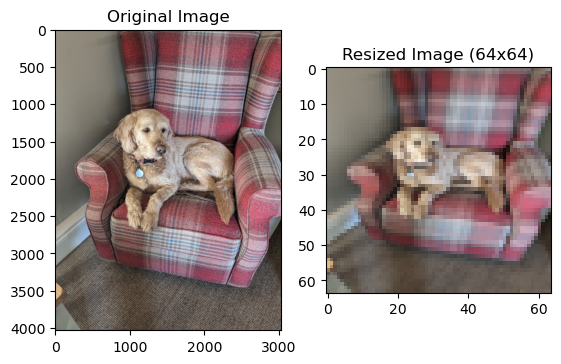

In [53]:
is_cat_tuned_regularized('toby.jpg')

y = 0, the model predicts this is a "non-cat" picture.


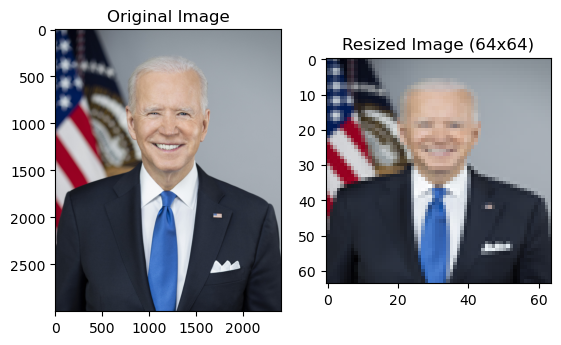

In [54]:
is_cat_tuned_regularized('mr_president.jpg')

y = 1, the model predicts this is a "cat" picture.


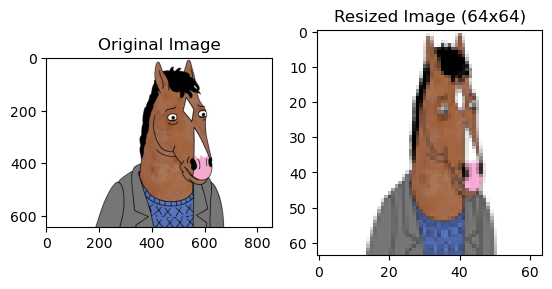

In [55]:
is_cat_tuned_regularized('bojack.jpg')

y = 1, the model predicts this is a "cat" picture.


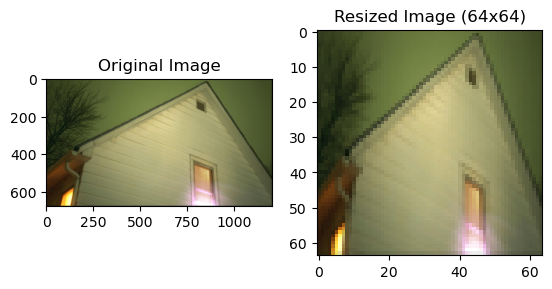

In [56]:
is_cat_tuned_regularized('american_football.jpg')

An improvement to be sure, but the model is still far from perfect. It seems that we have improved the validation accuracy at the expense of increasing the prevelence of false positives.

This might be because the validation set has a lot of cat images and we are overfitting to it, or because the images I am testing on are drawn from a different probability distribution than the images in the validation set.

We could investigate further by performing a more rigorous cross-validation process.

Adding hidden layers to the neural network would result in a more expressive model capable of telling apart cats and anthropomorphic cartoon horses or midwest emo album covers. We will explore these possiblities in later blog posts.